# Running FEISTY with time-series forcing from CESM

This notebook doesn't really need to be a notebook, I'm hoping it can be converted to a script instead.
All the parameter settings are handled in the first (non-`import`) cell, where we read in `feisty-config.TL319_t13.4p2z.001.yml`,
though in the loop over years the start / end dates and file I/O parameters are changed.
This was run on a casper login node with 4 GB of memory, but all data is kept distributed on the dask cluster.

## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import dask
import matplotlib.pyplot as plt
import nc_time_axis  # needed for time series plot for some reason
import numpy as np
import xarray as xr
import yaml
from dask.distributed import Client, wait
from dask_jobqueue import PBSCluster

import feisty

## Configure run

The FEISTY command `config_and_run_from_yaml()` needs a dictionary pointing to forcing streams and initial conditions.
We provide a few `YAML` files containing acceptable configurations.
There are also several parameters controlling how the run is set up.

In [3]:
# Read settings from YAML
feisty_config_file = 'feisty-config.TL319_t13.4p2z.001.yml'
with open(feisty_config_file) as f:
    feisty_config_in = yaml.safe_load(f)

outdir = os.path.join(os.path.sep, 'glade', 'scratch', os.environ['USER'], 'feisty_output')

In [4]:
def modify_forcing_dict(feisty_config, year, outdir='temp_forcing_streams'):
    """
    The highres run has a large list of files to read for the forcing dataset,
    and we want to create
    """

    import copy

    newfile_list = []
    years = np.arange(np.maximum(1980, start_year - 1), np.minimum(2021, start_year + nyears + 1))
    if not os.path.isdir(outdir):
        os.mkdir(outdir)
    for file in feisty_config['forcing']['streams']:
        newfile = f'{outdir}/{file.split("/")[-1]}'
        with open(file) as f:
            forcing_dict = yaml.safe_load(f)
        forcing_file_dict = {}
        for n, forcing_file in enumerate(forcing_dict['files']):
            forcing_file_dict[1980 + n] = forcing_file
        forcing_dict['files'] = [forcing_file_dict[year]]
        with open(newfile, 'w') as outfile:
            yaml.dump(forcing_dict, outfile)
        newfile_list.append(newfile)

    feisty_config_out = copy.deepcopy(feisty_config)
    feisty_config_out['forcing']['streams'] = newfile_list
    return feisty_config_out

## Set up Dask cluster

Since the data in `ds` is chunked in (`nlat`, `nlon`), we use a `dask` cluster to configure the parallelization

In [5]:
mem = 45  # GB
dask.config.set({'distributed.dashboard.link': 'proxy/{port}/status'})
cluster = PBSCluster(
    memory=f'{mem} GB',
    processes=1,
    cores=1,
    queue='casper',
    walltime='1:30:00',
    resource_spec=f'select=1:ncpus=1:mem={mem}GB',
    log_directory='./dask-logs',
)

cluster.scale(feisty_config_in['num_workers'])
client = Client(cluster)
client

/glade/work/mlevy/miniconda3/envs/dev-feisty/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42875 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: proxy/42875/status,
Dashboard: proxy/42875/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.55:38184,Workers: 0
Dashboard: proxy/42875/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [6]:
%%time

min_workers = feisty_config_in.get('min_workers', feisty_config_in['num_workers'])
worker_cnt = int(np.minimum(min_workers, feisty_config_in['num_workers']))
print(f"Waiting for {worker_cnt} workers (requested {feisty_config_in['num_workers']} total)")
client.wait_for_workers(worker_cnt)

Waiting for 72 workers (requested 72 total)
CPU times: user 514 ms, sys: 37.7 ms, total: 552 ms
Wall time: 10.8 s


## Run the model

In [7]:
%%time

start_year = 1980
nyears = 3
ds_list = list()
for year in range(start_year, start_year + nyears):
    feisty_config = modify_forcing_dict(feisty_config_in, year)
    print(f'Configuring FEISTY for {year}...')

    # Start and End dates
    feisty_config['start_date'] = f'{year}-01-01'
    feisty_config['end_date'] = f'{year}-12-31'
    # feisty_config['end_date'] = f'{year}-01-05'

    # Initialize from restart (unless this is first year)
    previous_restart = f'highres.{year-1}-12-31.zarr'
    if os.path.exists(os.path.join(outdir, 'rest', previous_restart)):
        feisty_config['initial_conditions'] = {
            'root_dir': os.path.join(outdir, 'rest'),
            'ic_file': previous_restart,
        }

    # Set up history and restart files for output
    feisty_config['output']['hist_dir'] = os.path.join(outdir, 'hist')
    feisty_config['output']['hist_file'] = f'highres.{year}.zarr'
    feisty_config['output']['rest_dir'] = os.path.join(outdir, 'rest')
    feisty_config['output']['rest_file'] = f'highres.{year}-12-31.zarr'

    # map_blocks lets us run in parallel over our dask cluster
    # for temp_file in feisty_config['forcing']['streams']:
    #     with open(temp_file) as f:
    #         temp_dict = yaml.safe_load(f)
    #     print(temp_dict['files'])
    # print(f'Running FEISTY for year {year}...')
    ds_list.append(feisty.config_and_run_from_yaml(feisty_config))

ds_out = xr.concat(ds_list, dim='time')
ds_out["biomass"]

Configuring FEISTY for 1980...
Starting template generation at 12:44:41
Writing /glade/scratch/mlevy/feisty_output/hist/highres.1980.zarr
Calling to_zarr...
Starting with biomass
Writing fish_yield to disk
Writing production to disk
Writing /glade/scratch/mlevy/feisty_output/rest/highres.1980-12-31.zarr
Calling to_zarr...
Configuring FEISTY for 1981...
Starting template generation at 12:59:13
Writing /glade/scratch/mlevy/feisty_output/hist/highres.1981.zarr
Calling to_zarr...
Starting with biomass
Writing fish_yield to disk
Writing production to disk
Writing /glade/scratch/mlevy/feisty_output/rest/highres.1981-12-31.zarr
Calling to_zarr...
Configuring FEISTY for 1982...
Starting template generation at 13:13:59
Writing /glade/scratch/mlevy/feisty_output/hist/highres.1982.zarr
Calling to_zarr...
Starting with biomass
Writing fish_yield to disk
Writing production to disk
Writing /glade/scratch/mlevy/feisty_output/rest/highres.1982-12-31.zarr
Calling to_zarr...
CPU times: user 3min 40s, sy

<xarray.DataArray 'biomass' (time: 1095, group: 9, nlat: 2400, nlon: 3600)>
dask.array<concatenate, shape=(1095, 9, 2400, 3600), dtype=float64, chunksize=(365, 9, 8, 1200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 1980-01-01 00:00:00 ... 1982-12-31 00:00:00
  * group    (group) object 'Sf' 'Sp' 'Sd' 'Mf' ... 'Lp' 'Ld' 'benthic_prey'
  * nlat     (nlat) int64 0 1 2 3 4 5 6 7 ... 2393 2394 2395 2396 2397 2398 2399
  * nlon     (nlon) int64 0 1 2 3 4 5 6 7 ... 3593 3594 3595 3596 3597 3598 3599

<!-- ### Plotting -->

Make a plot of `biomass` over time at a specified column,
then do the same for `fish_yield`

CPU times: user 204 ms, sys: 22.5 ms, total: 227 ms
Wall time: 422 ms


Text(0.5, 0.98, 'biomass at (91, 3175)')

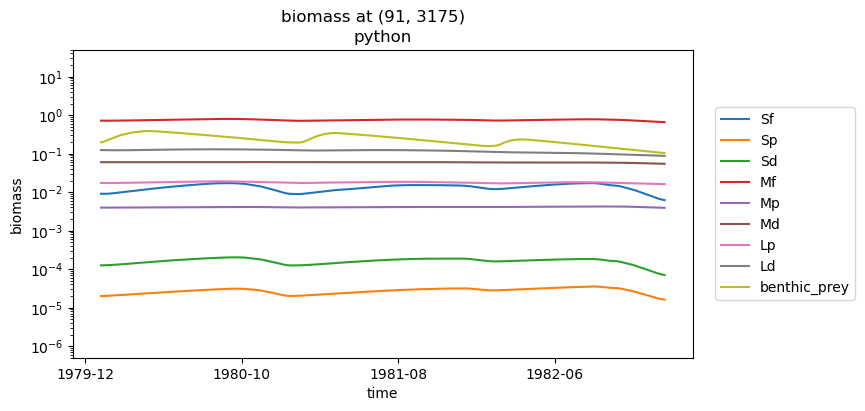

In [8]:
%%time

# Select column for time series plot
nlat = 91
nlon = 3175

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
for group in ds_out.group.data:
    ds_out['biomass'].isel(nlat=nlat, nlon=nlon).sel(group=group).plot()
ax.set_ylim([5e-7, 50])
ax.set_yscale("log")
ax.set_title("python")
plt.legend(ds_out.group.data, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"biomass at ({nlat}, {nlon})");

CPU times: user 174 ms, sys: 11 ms, total: 185 ms
Wall time: 246 ms


Text(0.5, 0.98, 'Fish yield at (91, 3175)')

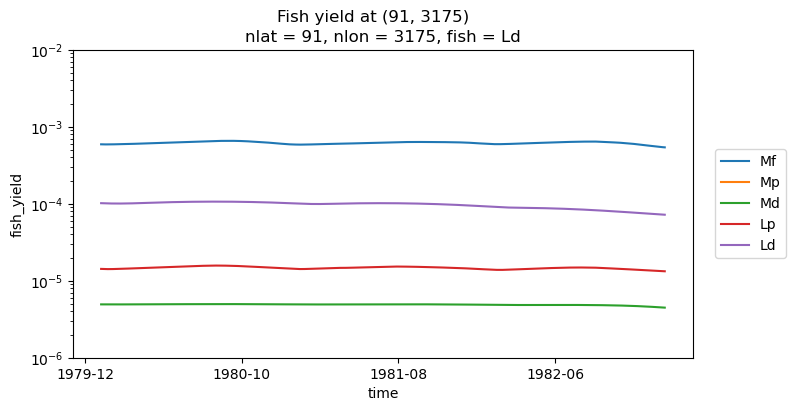

In [9]:
%%time

# Select column for time series plot
nlat = 91
nlon = 3175

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
plotted_fish = []
for fish in ds_out.fish.data:
    if np.nanmax(ds_out['fish_yield'].isel(nlat=nlat, nlon=nlon).sel(fish=fish).values) <= 0:
        continue
    plotted_fish.append(fish)
    ds_out['fish_yield'].isel(nlat=nlat, nlon=nlon).sel(fish=fish).plot()
ax.set_ylim([1e-6, 1e-2])
ax.set_yscale("log")
plt.legend(plotted_fish, bbox_to_anchor=(1.025, 0.5), loc=6)
fig.suptitle(f"Fish yield at ({nlat}, {nlon})");

In [10]:
# %%time

ds_out["biomass"].isel(time=0, group=0).max().values

array(0.89580934)

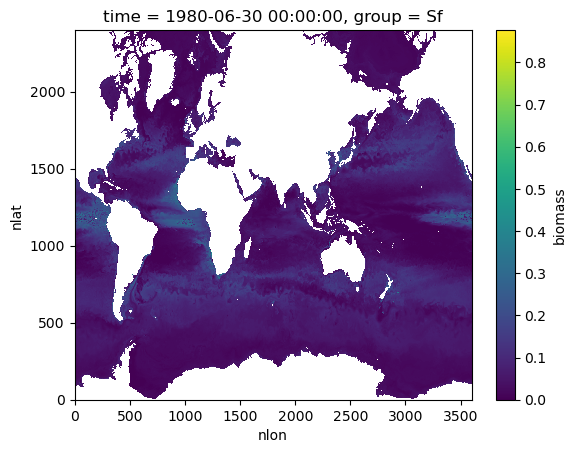

In [11]:
# %%time

ds_out["biomass"].isel(time=180, group=0).plot()

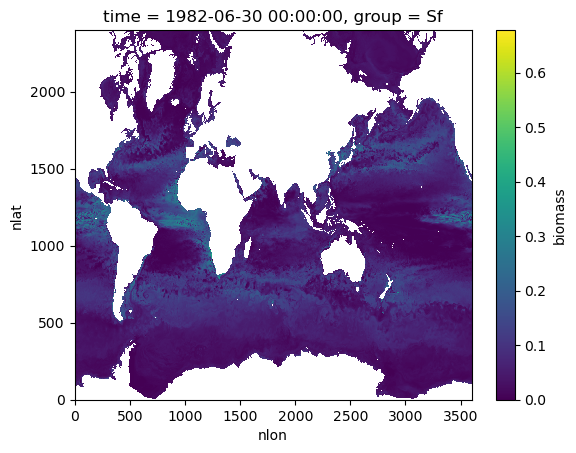

In [12]:
# %%time

ds_out["biomass"].isel(time=(nyears - 1) * 365 + 180, group=0).plot()

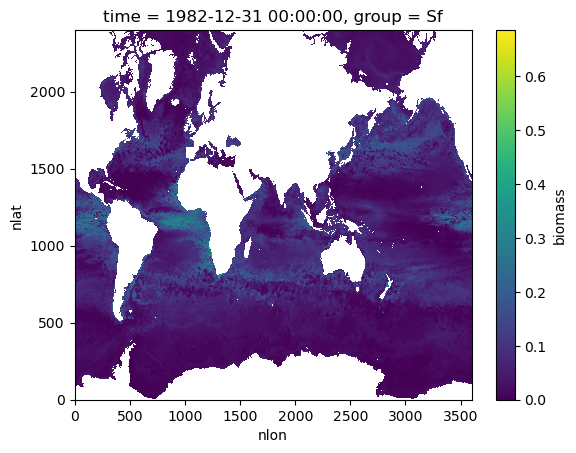

In [13]:
# %%time

ds_out["biomass"].isel(time=-1, group=0).plot()